In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import arange, array

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
housing = pd.read_csv('data/size_trimmed.csv')
housing.shape 
# 2523 x 86

(2523, 86)

In [4]:
housing.head()

,GrLivArea,MSSubClass,LotFrontage,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,GarageSize,Remodel_binary,LotPercent,Neighborhood_Num,Remodel_Qual,Remodel_GrLiv,Remodel_Bath,Remodel_Kitch,SalePrice,Log_SalePrice
0,856,1S_1945older,58.800593,6,6,1939,0.0,238.0,0.0,618.0,856.0,856,0,0,1.0,0.0,1,0,2,1,4,1,1939.0,399.0,0,0,0,0,166,0,0,3,2010,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,WD,Normal,large,1,0.108492,17,6,856,1,TA,126000,11.744037
1,1049,1S_PUD,42.000000,5,5,1984,149.0,552.0,393.0,104.0,1049.0,1049,0,0,1.0,0.0,2,0,2,1,5,0,1984.0,266.0,0,105,0,0,0,0,0,2,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,CBlock,Gd,TA,Mn,GLQ,ALQ,GasA,TA,Y,SBrkr,Gd,Typ,None,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,small,0,0.247698,7,0,0,0,NaN,139500,11.845820
2,1001,1S_1945older,60.000000,5,9,1930,0.0,737.0,0.0,100.0,837.0,1001,0,0,0.0,0.0,1,0,2,1,5,0,1930.0,216.0,154,0,42,86,0,0,0,11,2007,C (all),Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,Gd,TA,BrkTil,TA,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Detchd,Unf,TA,Po,N,None,None,None,WD,Normal,small,1,0.165182,5,5,1001,1,Gd,124900,11.735269
3,1039,2S_1945older,80.000000,4,8,1900,0.0,0.0,0.0,405.0,405.0,717,322,0,0.0,0.0,1,0,2,1,6,0,1940.0,281.0,0,0,168,0,111,0,0,5,2009,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,Gable,CompShg,MetalSd,MetalSd,None,Gd,Gd,BrkTil,Fa,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,None,Detchd,Unf,TA,TA,N,None,None,None,WD,Normal,small,1,0.088019,12,4,1039,1,TA,114000,11.643954
4,1665,2S_1946newer,70.000000,8,6,2001,0.0,643.0,0.0,167.0,810.0,810,855,0,1.0,0.0,2,1,3,1,6,0,2001.0,528.0,0,45,0,0,0,0,0,11,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,large,0,0.096429,23,0,0,0,NaN,227000,12.332705


## Pipeline: Model and Feature Set Comparison

In [5]:
col_transform = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), 
                 make_column_selector(dtype_include=object))], 
        verbose_feature_names_out = False
)

ridge_pipe = Pipeline(
    steps=[
        ("cols", col_transform), 
        ("regression", Ridge(alpha = 11))]
)

## Ridge Regression

In [42]:
X = housing.drop(['SalePrice', 'Log_SalePrice'], axis=1)
y = housing['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [64]:
ridge = ridge_pipe
ridge.fit(X_train, y_train)

print('train R^2: {}'.format(ridge.score(X_train, y_train)))
print('test R^2: {}'.format(ridge.score(X_test, y_test)))

train R^2: 0.9394786138202964
test R^2: 0.9333538069544433


In [84]:
y_true = y_test
y_pred = ridge.predict(X_test)
mean_squared_error(y_true, y_pred)

302506053.6418642

In [70]:
ridge_mod = ridge_pipe.named_steps['regression']
ridge_mod

Ridge(alpha=11)

In [ ]:
# plot residuals for test set only
y_true = y_test
y_pred = ridge.predict(X_test)
mean_squared_error(y_true, y_pred)

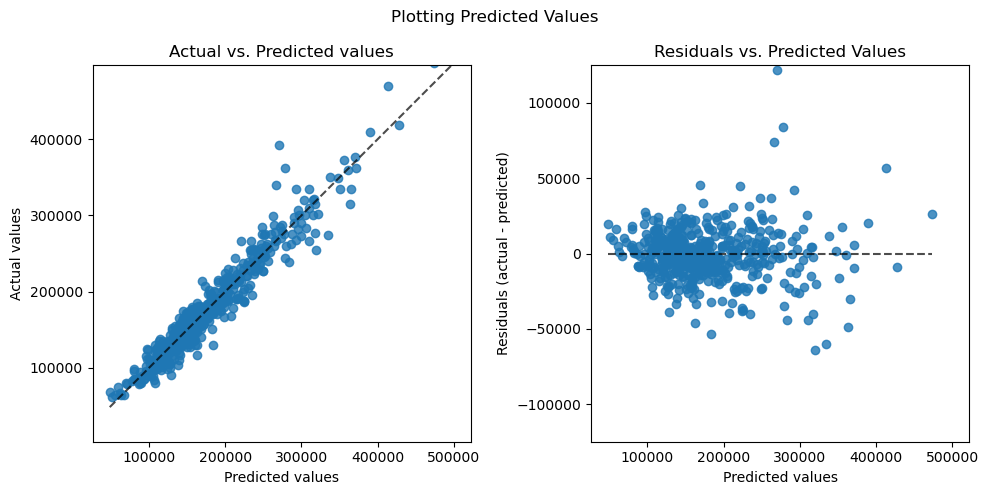

In [103]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex = True)

PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
#axs[0].set_xlim(0, 500000)
axs[0].set_xticks(arange(100000, 600000,100000))
axs[0].set_ylim(0, 500000)
axs[0].set_yticks(arange(100000, 500000,100000))

PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
axs[1].set_ylim(-125000, 125000)

fig.suptitle("Plotting Predicted Values")
plt.tight_layout()
plt.show()

In [112]:
# plot residuals for all data
y_true = y
y_pred = ridge.predict(X)
mean_squared_error(y_true, y_pred)

289665848.879075

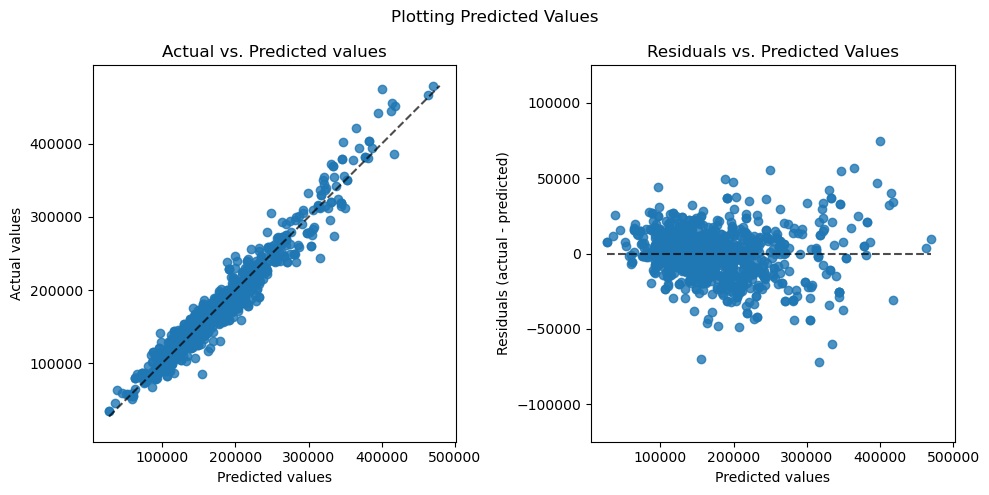

In [113]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex = True)

PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
axs[0].set_xticks(arange(100000, 600000,100000))
axs[0].set_ylim(0, 500000)
axs[0].set_yticks(arange(100000, 500000,100000))

PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
axs[1].set_ylim(-125000, 125000)

fig.suptitle("Plotting Predicted Values")
plt.tight_layout()
plt.show()

In [ ]:
# while test set has more outliers with high positive residuals
# overall dataset has more outlier with high negative residuals

# residuals = actual - predicted
# when residual is negative, predicted is greater than actual
# these homes were undervalued in sale price, according to the model

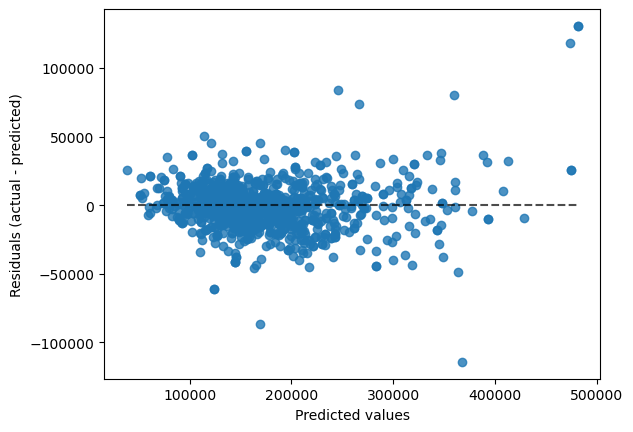

In [119]:
disp = PredictionErrorDisplay.from_predictions(y_true=y_true, y_pred=y_pred)
plt.show()

In [138]:
resid = pd.DataFrame((y_true - y_pred), index = X.index)
resid.columns = ['res']
resid

,res
0,7270.765933
1,7307.430358
2,-8079.575237
3,14642.851111
4,11377.749456
...,...
2518,2201.682229
2519,3883.714967
2520,-17434.555392
2521,-5099.247227


array([[<Axes: title={'center': 'SalePrice'}>]], dtype=object)

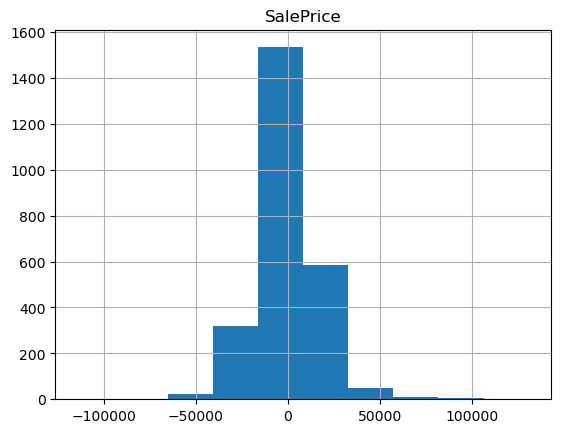

In [125]:
resid.hist()

In [140]:
# identify points with above/below 50,000 in residue
resid[resid['res'] < -50000].shape # 9 homes
resid[resid['res'] > 50000].shape #24 homes

(24, 1)

In [157]:
abs_error = abs(resid)
abs_error.sort_values('res', ascending = False)
# highest prediction error is over 130k

,res
570,130703.268657
602,122078.777057
600,118367.318458
500,114172.552638
64,103853.340142
...,...
586,36.409685
998,35.706307
1497,25.636877
1057,10.415848


In [160]:
resid.sort_values('res', ascending = True).head(10)
# top 10 undervalued homes have predicted sale price at least 50k above actual sale price

,res
500,-114172.552638
178,-86773.136000
1993,-71930.647549
973,-70144.942471
2238,-64399.196337
1692,-63789.685815
1494,-61187.494180
1873,-60192.763885
1962,-53327.077833
657,-48816.816674


In [164]:
# examine homes where predicted value is above actual sale price
housing['y_pred'] = ridge.predict(X)
housing['resid'] = resid['res']
homes_underval = housing[housing['resid'] < 0]

In [165]:
homes_underval.shape
# about half of the observations

(1270, 88)

In [169]:
homes_underval.describe()

,GrLivArea,LotFrontage,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Remodel_binary,LotPercent,Neighborhood_Num,Remodel_Qual,Remodel_GrLiv,Remodel_Bath,SalePrice,Log_SalePrice,y_pred,resid
count,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000
mean,1463.113386,70.979577,6.070866,5.622835,1970.146457,101.507087,460.362205,55.674803,529.248031,1045.285039,1146.614961,313.517323,2.981102,0.445669,0.059055,1.537008,0.366142,2.800787,1.039370,6.332283,0.611811,1975.070866,458.594364,91.584252,45.308661,23.258268,2.150394,18.600787,1.361417,58.155118,6.137008,2007.791339,0.474016,0.139589,13.803150,2.802362,704.912598,0.709449,165593.884252,11.959816,177680.856113,-12086.971861
std,413.937869,30.861476,1.242034,1.138321,29.716082,174.104661,420.692676,179.343063,422.869783,399.519896,351.470549,399.228785,31.666624,0.511300,0.242412,0.521984,0.498021,0.800216,0.202489,1.441744,0.658115,26.111714,203.569397,126.905040,65.556086,61.313269,20.741538,59.898447,29.278036,640.290583,2.711235,1.292430,0.499521,0.070121,7.714303,3.077332,800.530952,0.834532,56645.924683,0.346003,58847.139481,11067.067165
min,334.000000,12.669329,1.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.020317,1.000000,0.000000,0.000000,0.000000,12789.000000,9.456341,40659.280163,-114172.552638
25%,1143.250000,56.048050,5.000000,5.000000,1953.000000,0.000000,0.000000,0.000000,200.000000,802.250000,886.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,322.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,0.000000,0.096912,6.000000,0.000000,0.000000,0.000000,128050.000000,11.760176,137755.400520,-17180.090763
50%,1440.500000,68.000000,6.000000,5.000000,1972.000000,0.000000,426.000000,0.000000,440.000000,994.000000,1085.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,478.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,0.000000,0.121310,12.500000,0.000000,0.000000,0.000000,157000.000000,11.964001,167014.590630,-9216.554094
75%,1710.000000,80.086157,7.000000,6.000000,1999.000000,165.500000,775.750000,0.000000,776.000000,1280.750000,1370.000000,675.750000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,1999.000000,572.750000,164.750000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,1.000000,0.158306,20.000000,6.000000,1445.500000,1.000000,192000.000000,12.165251,207367.872648,-4123.728730
max,2654.000000,426.285668,10.000000,9.000000,2008.000000,1600.000000,1880.000000,1526.000000,2336.000000,3206.000000,2524.000000,1611.000000,514.000000,2.000000,2.000000,4.000000,2.000000,6.000000,3.000000,12.000000,4.000000,2009.000000,1488.000000,1424.000000,742.000000,584.000000,320.000000,576.000000,800.000000,15500.000000,12.000000,2010.000000,1.000000,0.517647,28.000000,10.000000,2654.000000,4.000000,419005.000000,12.945638,428082.190862,-7.222279


In [167]:
housing.describe()

,GrLivArea,LotFrontage,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Remodel_binary,LotPercent,Neighborhood_Num,Remodel_Qual,Remodel_GrLiv,Remodel_Bath,SalePrice,Log_SalePrice,y_pred,resid
count,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000
mean,1452.151407,72.143899,6.001982,5.617519,1970.058660,92.941736,437.759413,52.468886,534.977804,1025.206104,1130.567578,317.817281,3.766548,0.430440,0.061831,1.531906,0.364645,2.825208,1.040032,6.315101,0.585018,1974.992073,460.674928,93.032501,44.686881,23.317083,2.567975,15.550931,1.403488,48.583829,6.135157,2007.840270,0.459770,0.137896,13.540626,2.686881,678.681728,0.684503,173974.583432,11.997017,174091.819589,-117.236156
std,433.961964,46.369361,1.336813,1.115088,29.637121,164.962030,423.455643,170.316467,421.993023,407.847898,359.179171,403.318980,41.680678,0.515633,0.244166,0.529907,0.492822,0.804901,0.202048,1.461167,0.636117,26.060031,203.608723,126.172181,63.547408,64.215260,25.575324,54.711493,28.543324,502.300500,2.673401,1.313721,0.498478,0.074579,7.663072,3.060106,798.184624,0.828914,68538.542616,0.372776,66170.954428,17022.542546
min,334.000000,11.424754,1.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.009082,1.000000,0.000000,0.000000,0.000000,12789.000000,9.456341,26945.358993,-114172.552638
25%,1102.500000,58.000000,5.000000,5.000000,1953.000000,0.000000,0.000000,0.000000,212.000000,784.000000,866.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,312.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,0.000000,0.093899,6.000000,0.000000,0.000000,0.000000,129450.000000,11.771050,128737.604300,-9295.379006
50%,1426.000000,69.000000,6.000000,5.000000,1971.000000,0.000000,380.000000,0.000000,447.000000,972.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,471.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,0.000000,0.119012,12.000000,0.000000,0.000000,0.000000,158000.000000,11.970350,159907.055083,-128.556817
75%,1716.500000,80.159592,7.000000,6.000000,1999.000000,146.000000,725.500000,0.000000,780.000000,1248.000000,1340.500000,684.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,1999.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,1.000000,0.154815,19.500000,6.000000,1405.000000,1.000000,204375.000000,12.227710,207903.919576,8542.452964
max,2654.000000,1227.136330,10.000000,9.000000,2010.000000,1600.000000,2257.000000,1526.000000,2336.000000,3206.000000,2633.000000,1788.000000,1064.000000,3.000000,2.000000,4.000000,2.000000,6.000000,3.000000,13.000000,4.000000,2010.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,15500.000000,12.000000,2010.000000,1.000000,0.520548,28.000000,10.000000,2654.000000,4.000000,615000.000000,13.329378,511146.659858,130703.268657


<Axes: >

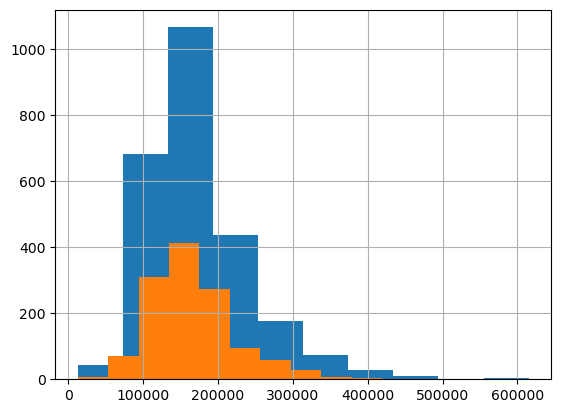

In [170]:
# homes that are undervalued have a similar distribution to homes overall
housing['SalePrice'].hist()
homes_underval['SalePrice'].hist()

In [171]:
# view undervalued homes with the greatest error
homes_underval.sort_values('resid', ascending = True).head(10)

,GrLivArea,MSSubClass,LotFrontage,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,GarageSize,Remodel_binary,LotPercent,Neighborhood_Num,Remodel_Qual,Remodel_GrLiv,Remodel_Bath,Remodel_Kitch,SalePrice,Log_SalePrice,y_pred,resid
500,2042,1S_1946newer,98.000000,8,5,2008,306.0,0.0,0.0,2042.0,2042.0,2042,0,0,0.0,0.0,2,1,3,1,8,1,2009.0,1390.0,0,90,0,0,0,0,0,8,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,BrkFace,Ex,TA,PConc,Ex,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,RFn,TA,TA,Y,None,None,None,New,Partial,large,1,0.160737,27,8,2042,2,Ex,253293,12.442302,367465.552638,-114172.552638
178,1411,1S_1946newer,85.000000,7,5,1977,209.0,822.0,0.0,564.0,1386.0,1411,0,0,0.0,0.0,2,0,3,1,6,1,1977.0,544.0,192,0,0,0,0,0,0,4,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Plywood,Plywood,BrkFace,TA,Gd,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,None,None,None,WD,Family,large,0,0.118571,23,0,0,0,NaN,82500,11.320554,169273.136000,-86773.136000
1993,2223,1S_1946newer,95.000000,7,6,1973,1115.0,1880.0,0.0,343.0,2223.0,2223,0,0,1.0,0.0,2,0,3,1,8,2,1973.0,516.0,300,0,0,0,0,0,0,2,2007,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,BrkFace,TA,Gd,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal,large,0,0.162845,6,0,0,0,NaN,244000,12.404924,315930.647549,-71930.647549
973,1728,duplex,98.000000,5,6,1962,144.0,1500.0,0.0,228.0,1728.0,1728,0,0,2.0,0.0,2,0,6,2,10,0,1962.0,0.0,0,0,0,0,0,0,0,1,2010,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,Duplex,1Story,Hip,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,No,BLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,None,None,None,None,None,Y,None,None,None,Oth,Abnorml,small,1,0.130317,6,5,1728,2,TA,84900,11.349229,155044.942471,-70144.942471
2238,2362,1S_1946newer,80.000000,7,6,1980,600.0,1732.0,0.0,270.0,2002.0,2362,0,0,1.0,0.0,2,1,3,1,8,1,1980.0,546.0,180,16,0,0,0,0,0,3,2007,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,MetalSd,BrkFace,Gd,TA,CBlock,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,Gd,TA,Y,None,None,None,WD,Normal,large,0,0.196833,24,0,0,0,NaN,255000,12.449019,319399.196337,-64399.196337
1692,2207,1S_1946newer,148.305678,7,5,1970,287.0,912.0,0.0,1035.0,1947.0,2207,0,0,1.0,0.0,2,0,3,1,7,1,1970.0,576.0,301,0,0,0,0,0,0,7,2010,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,PosA,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,BrkFace,TA,TA,CBlock,Gd,TA,Gd,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Min1,Gd,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,large,1,0.110905,6,7,2207,2,TA,180000,12.100712,243789.685815,-63789.685815
1494,864,1S_1946newer,60.000000,5,5,1965,0.0,553.0,311.0,0.0,864.0,864,0,0,0.0,0.0,1,0,3,1,5,1,1965.0,360.0,0,0,236,0,0,0,0,12,2009,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,Rec,BLQ,GasA,Gd,Y,SBrkr,TA,Typ,Po,Detchd,Unf,TA,TA,Y,None,GdWo,None,WD,Normal,small,0,0.104335,1,0,0,0,NaN,62383,11.041048,123570.494180,-61187.494180
1873,1518,1S_PUD,62.000000,8,5,2003,472.0,1218.0,0.0,300.0,1518.0,1518,0,0,0.0,0.0,1,1,1,1,6,1,2003.0,588.0,185,140,0,0,0,0,0,4,2008,RL,

In [65]:
# explore top 100 undervalued homes
underval_top = homes_underval.sort_values('error', ascending = True).head(100)
underval_top

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Remodel_binary,GarageSize,TotalIndoorSF,LotPercent,LivArea_sq,Log_LivArea,Neighborhood_Num,Remodel_Qual,Remodel_GrLiv,Remodel_TotSF,Remodel_Bath,SalePrice,Log_SalePrice,y_pred,error
427,832,1S_1945older,68.000000,9656,2,2,1923,1970,0.0,0.0,0.0,678.0,678.0,832,0,0,0.0,0.0,1,0,2,1,5,1,1928.0,2.0,780.0,0,0,0,0,0,0,0,6,2010,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,Gable,CompShg,AsbShng,AsbShng,None,TA,Fa,BrkTil,Fa,Fa,No,Unf,Unf,GasA,TA,N,SBrkr,TA,Typ,Gd,Detchd,Unf,Fa,Fa,N,None,None,None,WD,Abnorml,1,large,1510.0,0.086164,692224,6.723832,12,2,832,1510.0,1,12789,9.456341,10.761646,-1.305305
309,4676,2S_1946newer,130.000000,40094,10,5,2007,2008,762.0,2260.0,0.0,878.0,3138.0,3138,1538,0,1.0,0.0,3,1,3,1,11,1,2007.0,3.0,884.0,208,406,0,0,0,0,0,10,2007,RL,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,BuiltIn,Fin,TA,TA,Y,None,None,None,New,Partial,1,large,7814.0,0.078266,21864976,8.450198,7,10,4676,7814.0,3,184750,12.126759,13.183023,-1.056265
180,1411,1S_1946newer,85.000000,11900,7,5,1977,1977,209.0,822.0,0.0,564.0,1386.0,1411,0,0,0.0,0.0,2,0,3,1,6,1,1977.0,2.0,544.0,192,0,0,0,0,0,0,4,2009,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Plywood,Plywood,BrkFace,TA,Gd,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,None,None,None,WD,Family,0,large,2797.0,0.118571,1990921,7.252054,23,0,0,0.0,0,82500,11.320554,11.977593,-0.657039
740,1317,2S_1945older,50.000000,8500,4,4,1920,1950,0.0,0.0,0.0,649.0,649.0,649,668,0,0.0,0.0,1,0,3,1,6,0,1920.0,1.0,250.0,0,54,172,0,0,0,0,7,2008,C (all),Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,Gambrel,CompShg,BrkFace,BrkFace,None,TA,Fa,BrkTil,TA,TA,No,Unf,Unf,GasA,TA,N,SBrkr,TA,Typ,None,Detchd,Unf,TA,Fa,N,None,MnPrv,None,WD,Normal,1,small,1966.0,0.076353,1734489,7.183112,5,4,1317,1966.0,1,40000,10.596635,11.224761,-0.628126
1533,864,1S_1946newer,60.000000,8281,5,5,1965,1965,0.0,553.0,311.0,0.0,864.0,864,0,0,0.0,0.0,1,0,3,1,5,1,1965.0,1.0,360.0,0,0,236,0,0,0,0,12,2009,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,Rec,BLQ,GasA,Gd,Y,SBrkr,TA,Typ,Po,Detchd,Unf,TA,TA,Y,None,GdWo,None,WD,Normal,0,small,1728.0,0.104335,746496,6.761573,1,0,0,0.0,0,62383,11.041048,11.642280,-0.601232
275,2944,2S_1946newer,183.123976,24572,9,3,1977,1977,1050.0,410.0,0.0,584.0,994.0,1599,1345,0,0.0,0.0,2,2,3,1,9,1,1977.0,3.0,864.0,140,70,16,0,0,0,0,6,2008,RL,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Veenker,Norm,Norm,1Fam,2Story,Mansard,CompShg,Wd Sdng,Wd Sdng,BrkFace,Gd,Gd,CBlock,Gd,TA,No,GLQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,None,None,None,WD,Family,0,large,3938.0,0.065074,8667136,7.987524,24,0,0,0.0,0,150000,11.918391,12.472610,-0.554219
558,720,1S_1945older,60.000000,7879,4,5,1920,1950,0.0,495.0,0.0,225.0,720.0,720,0,0,0.0,0.0,1,0,2,1,4,0,1920.0,0.0,0.0,0,523,115,0,0,0,0,11,2009,C (all),Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Un

In [72]:
# look at how feature relationships are different for undervalued homes
housing_newfeat.corr()['SalePrice'].sort_values(ascending = False)

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_52886/620734344.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  housing_newfeat.corr()['SalePrice'].sort_values(ascending = False)


SalePrice           1.000000
Log_SalePrice       0.950051
y_pred              0.928560
TotalIndoorSF       0.819266
OverallQual         0.790501
GrLivArea           0.719981
LivArea_sq          0.699848
Log_LivArea         0.699264
TotalBsmtSF         0.652494
1stFlrSF            0.642613
GarageCars          0.638785
GarageArea          0.634976
Neighborhood_Num    0.627622
YearBuilt           0.544370
FullBath            0.534982
GarageYrBlt         0.532087
YearRemodAdd        0.514309
MasVnrArea          0.498432
TotRmsAbvGrd        0.490219
Fireplaces          0.488184
BsmtFinSF1          0.461070
WoodDeckSF          0.333232
OpenPorchSF         0.306540
BsmtFullBath        0.290755
HalfBath            0.285875
LotArea             0.274443
2ndFlrSF            0.263144
error               0.237390
LotFrontage         0.208847
Remodel_TotSF       0.193966
Remodel_GrLiv       0.175859
BsmtUnfSF           0.168060
BedroomAbvGr        0.151806
Remodel_Bath        0.130500
Remodel_Qual  

In [73]:
underval_top.corr()['SalePrice'].sort_values(ascending = False)
# features that have higher correlation with price:
# GarageCars

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_52886/2218614092.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  underval_top.corr()['SalePrice'].sort_values(ascending = False)


SalePrice           1.000000
y_pred              0.932231
Log_SalePrice       0.931845
OverallQual         0.781950
TotalIndoorSF       0.735742
Log_LivArea         0.721212
GarageCars          0.699019
1stFlrSF            0.688473
GrLivArea           0.686252
GarageArea          0.630438
Fireplaces          0.622229
TotalBsmtSF         0.615444
YearBuilt           0.611139
YearRemodAdd        0.584684
Neighborhood_Num    0.583470
GarageYrBlt         0.580907
BsmtFinSF1          0.578012
WoodDeckSF          0.550923
LivArea_sq          0.542872
FullBath            0.526494
MasVnrArea          0.495189
TotRmsAbvGrd        0.472768
BsmtFullBath        0.402954
HalfBath            0.383535
OverallCond         0.327628
3SsnPorch           0.324606
LotFrontage         0.308275
LotArea             0.288927
error               0.243551
2ndFlrSF            0.231108
LotPercent          0.213123
BedroomAbvGr        0.179286
BsmtFinSF2          0.162224
Remodel_GrLiv       0.149243
Remodel_TotSF 

In [ ]:
# interpret model coefficients 

In [23]:
coefs_ridge = pd.DataFrame(ridge.coef_, index = X_train.columns, columns = ['coef'])
coefs_ridge.sort_values('coef', ascending = False)

,coef
Log_LivArea,0.070404
GrLivArea,0.062437
OverallQual,0.058134
Neighborhood_Crawfor,0.052804
SaleCondition_Normal,0.050650
...,...
Functional_Maj2,-0.043530
Condition2_PosN,-0.049981
MSZoning_C (all),-0.057785
LivArea_sq,-0.062280


In [29]:
coefs_ridge_absv = abs(coefs_ridge)
coefs_ridge_absv.sort_values('coef', ascending = False).head(20)

,coef
Log_LivArea,0.070404
SaleCondition_Abnorml,0.067692
GrLivArea,0.062437
LivArea_sq,0.062280
OverallQual,0.058134
MSZoning_C (all),0.057785
Neighborhood_Crawfor,0.052804
SaleCondition_Normal,0.050650
OverallCond,0.050469
Condition2_PosN,0.049981


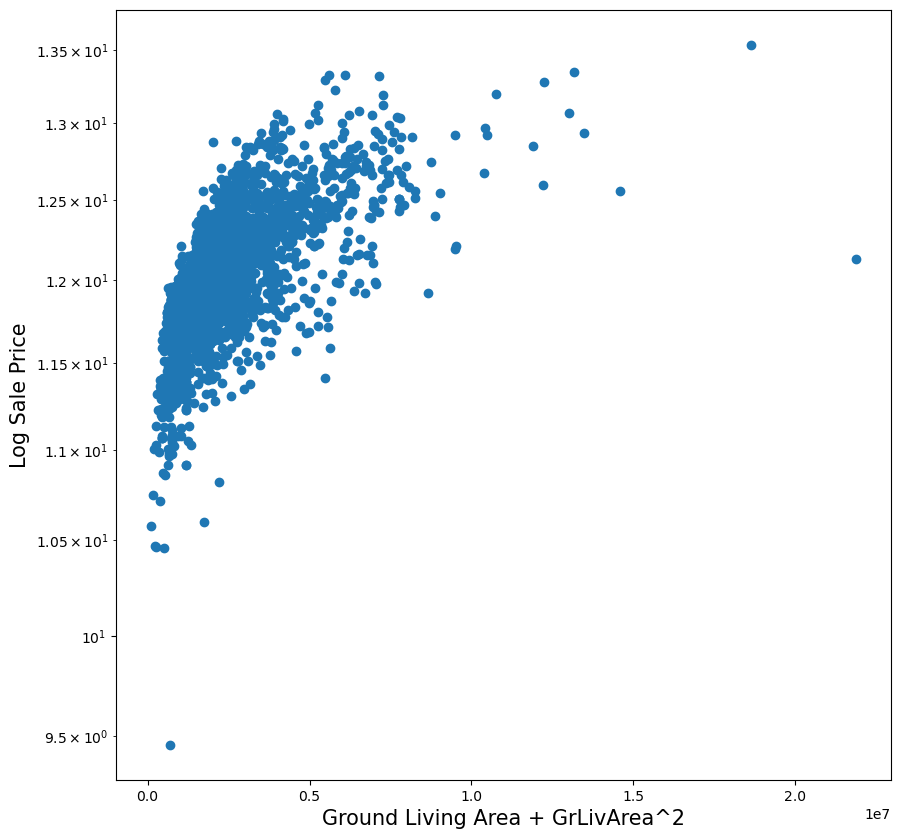

In [28]:
plt.figure(figsize=(10,10))
#plt.scatter(y_true, y_pred, c='crimson')
plt.yscale('log')
#plt.xscale()

plt.scatter(housing_newfeat['GrLivArea'] + housing_newfeat['LivArea_sq'], y)
plt.plot(housing_newfeat['GrLivArea'] + housing_newfeat['LivArea_sq'], y)

plt.xlabel('Ground Living Area + GrLivArea^2', fontsize=15)
plt.ylabel('Log Sale Price', fontsize=15)
plt.show()

In [ ]:
# fit_transform on all X
X_transformed = col_transform.fit_transform(X)
new_feat_names = col_transform.get_feature_names_out()
X = pd.DataFrame(X_transformed, columns = new_feat_names)

# or # fit on train only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
ct = col_transform.fit(X_train)
X = ct.transform(X) # returns array